# Natural Processing Languague


```Dataset: EmoEvent ```

EmoEvent es un corpus de tweets en español y inglés diseñado específicamente para la tarea de clasificación de emociones en el contexto de eventos de Twitter. A diferencia de conjuntos de datos genéricos, EmoEvent se caracteriza porque cada tweet está asociado a un evento particular (ej: "GameOfThrones", "NotreDame", "Venezuela"), lo que añade una capa de complejidad y contexto crucial para el análisis.


**¿Qué encontraremos en este dataset?**

El dataset está compuesto por 8,409 tweets en español, anotados manualmente con dos niveles de información:

***Emoción Principal (emotion):*** La categoría emocional principal del tweet. El modelo deberá aprender a predecir una de las siguientes 8 clases:

Ira (anger)

Tristeza (sadness)

Alegría (joy)

Asco (disgust)

Miedo (fear)

Sorpresa (surprise)

Ofensivo (offensive)

Otros (others) - Para tweets que no expresan una emoción clara de las anteriores.

***Etiqueta de Ofensividad (offensive):*** Una clasificación binaria que indica si el contenido del tweet es considerado ofensivo (OFF) o no ofensivo (NO). Esta etiqueta está fuertemente correlacionada con la emoción de "ira" (anger), pero no es exclusiva de ella.

## 1. Preparación del entorno

In [4]:
!pip install transformers torch torchvision torchaudio --quiet
!pip install seaborn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Para evaluación

## 2. Carga del dataset

In [5]:
!git clone https://github.com/fmplaza/EmoEvent.git # Descargar del dataset desde GitHub

fatal: destination path 'EmoEvent' already exists and is not an empty directory.


In [6]:
!find EmoEvent -type f -name "*.csv"


EmoEvent/emoevent_es.csv
EmoEvent/emoevent_en.csv


In [7]:
df_train = pd.read_csv("EmoEvent/splits/es/train.tsv", sep="\t")
df_dev   = pd.read_csv("EmoEvent/splits/es/dev.tsv", sep="\t")
df_test  = pd.read_csv("EmoEvent/splits/es/test.tsv", sep="\t")

print("Tamaño train:", df_train.shape)
print("Tamaño dev:", df_dev.shape)
print("Tamaño test:", df_test.shape)

print("\nColumnas disponibles:", df_train.columns.tolist())
df_train.head()

Tamaño train: (5723, 5)
Tamaño dev: (844, 5)
Tamaño test: (1656, 5)

Columnas disponibles: ['id', 'event', 'tweet', 'offensive', 'emotion']


,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness


/tmp/ipython-input-1662017143.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")


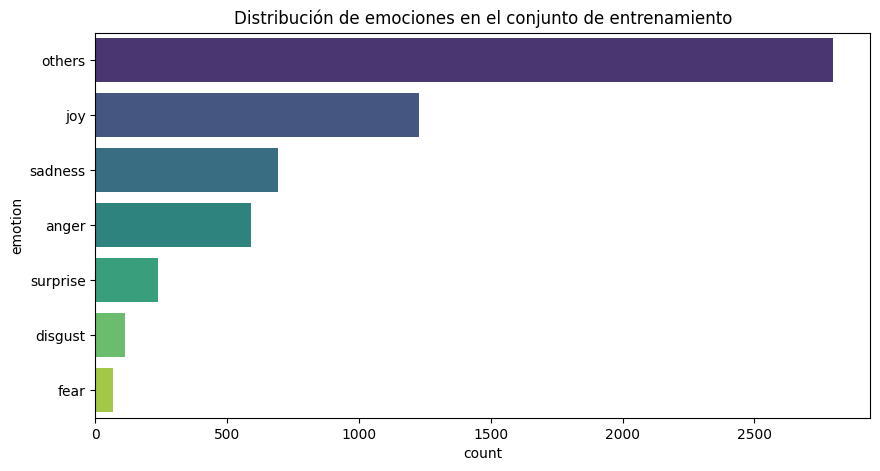

In [8]:
# ===============================================
# Distribución de emociones en entrenamiento
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")
plt.title("Distribución de emociones en el conjunto de entrenamiento")
plt.show()


La distribución de emociones en el conjunto de entrenamiento revela un desbalanceo significativo entre clases, donde la categoría `others` aparece como abrumadoramente mayoritaria, mientras que emociones como `surprise`, `disgust` y `fear `están notablemente subrepresentadas. Esta desigualdad plantea un desafío crucial para el modelado, ya que existe el riesgo de que un algoritmo optimice sus predicciones hacia la clase dominante, obteniendo una precisión engañosa mientras falla en reconocer las emociones minoritarias. Por esta razón, la evaluación del modelo no puede basarse en la `accuracy convencional`, sino que debe priorizar el `F1-Score macro`, que pondera por igual el desempeño en todas las clases, junto con un análisis detallado de la matriz de confusión para identificar los patrones de error entre emociones morfológicamente similares. El éxito del modelo dependerá de su capacidad para generalizar beyond de las clases frecuentes y capturar también los matices de las emociones menos representadas.



/tmp/ipython-input-567717094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["event"], order=df_train["event"].value_counts().index[:10], palette="mako")


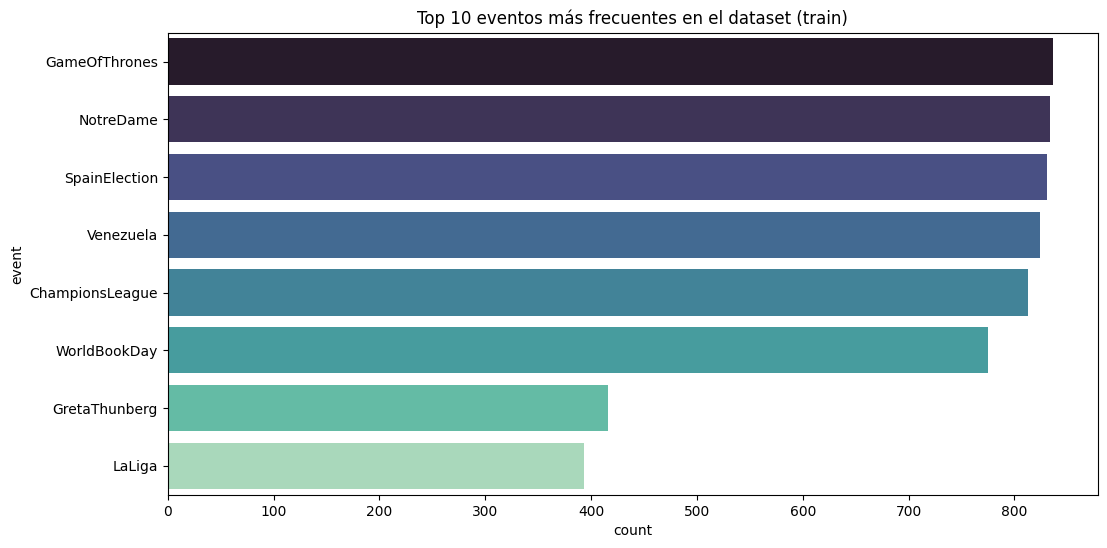

In [9]:
# =====================================
# Top 10 eventos más frecuentes
# =====================================
plt.figure(figsize=(12,6))
sns.countplot(y=df_train["event"], order=df_train["event"].value_counts().index[:10], palette="mako")
plt.title("Top 10 eventos más frecuentes en el dataset (train)")
plt.show()

El gráfico de los eventos más frecuentes revela una distribución desigual en el conjunto de datos, donde `GameOfThrones` y `NotreDame` emergen como los eventos dominantes con una cantidad significativamente mayor de tweets en comparación con los demás. Esta concentración sugiere que el dataset podría estar sesgado hacia ciertos temas particulares, lo que potencialmente afectaría la generalización del modelo hacia eventos menos representados.

 La presencia mayoritaria de eventos culturales y deportivos como GameOfThrones, ChampionsLeague y LaLiga, junto con eventos sociales y políticos como Venezuela y SpainElection, indica una diversidad temática pero con una representación dispar. Este desbalanceo podría influir en el desempeño del modelo, ya que tendrá más ejemplos para aprender patrones lingüísticos y emocionales asociados a eventos populares como GameOfThrones, mientras que eventos como GretaThunberg o WorldBookDay contarían con menos datos para un aprendizaje robusto.

 Por lo tanto, es crucial evaluar el modelo no solo globalmente, sino también desglosando su rendimiento por tipo de evento para identificar posibles sesgos temáticos.



In [10]:
# Mostrar un ejemplo de tweet por cada emoción
for emotion in df_train["emotion"].unique():
    ejemplo = df_train[df_train["emotion"] == emotion].sample(1, random_state=42)
    print(f"Emoción: {emotion}")
    print("Tweet:", ejemplo["tweet"].values[0])
    print("-"*50)

Emoción: others
Tweet: He perdido 5 años con el último capítulo de #JuegodeTronos
--------------------------------------------------
Emoción: sadness
Tweet: Aunque es un alivio que no haya que lamentar daños humanos, en este caso los materiales son irremplazables. Muuuy triste 😭 #NotreDame https://t.co/ku2goMOqJ1
--------------------------------------------------
Emoción: joy
Tweet: Esta noche? La mejor noche de mi vida #ElecccionesGenerales28A #JuegodeTronos 🐺
--------------------------------------------------
Emoción: anger
Tweet: Si gana el PSOE, menuda fiesta de Putas y farlopa se van a pegar día sí, día también, a ver si por lo menos lo regulan y pagan impuestos.... Algo sacaremos. #ElecccionesGenerales28A
--------------------------------------------------
Emoción: surprise
Tweet: ¿Soy el único al que le extraña un fuego accidental por labores de renovación precisamente en #NotreDame?
--------------------------------------------------
Emoción: disgust
Tweet: ¿La Sexta y TVE han sa

## Preprocesamiento

In [11]:
import re

def clean_tweet(text):
    if pd.isna(text):  # si es NaN, devolvemos cadena vacía
        return ""
    text = str(text).lower()  # todo en minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # eliminar URLs
    text = re.sub(r"@\w+", "", text)  # eliminar menciones
    text = re.sub(r"#", "", text)  # quitar el símbolo de hashtag
    text = re.sub(r"[^a-zA-Záéíóúüñ\s]", "", text)  # quitar caracteres especiales
    text = re.sub(r"\s+", " ", text).strip()  # eliminar espacios extra
    return text



El preprocesamiento aplicado a los tweets busca estandarizar el texto y eliminar elementos que añaden ruido sin aportar valor semántico para la clasificación de emociones. La conversión a minúsculas asegura consistencia en el tratamiento de palabras, mientras que la eliminación de URLs, menciones de usuario (@usuario) y el símbolo de hashtag (#) responde a que estos elementos son comunes en tweets pero no contienen carga emocional directa. La eliminación de caracteres especiales preserva únicamente letras y espacios, lo que ayuda a reducir la dimensionalidad del vocabulario. Finalmente, la normalización de espacios elimina redundancias y asegura una tokenización coherente. Este proceso busca maximizar la señal lingüística relevante para que los modelos identifiquen mejor los patrones emocionales en el texto

In [12]:
# Aplicar limpieza a los tweets
df_train["tweet_clean"] = df_train["tweet"].apply(clean_tweet)
df_dev["tweet_clean"]   = df_dev["tweet"].apply(clean_tweet)
df_test["tweet_clean"]  = df_test["tweet"].apply(clean_tweet)

# Ver ejemplos
df_train[["tweet", "tweet_clean", "emotion"]].head(5)


,tweet,tweet_clean,emotion
0,La Gran Guerra de #JuegoDeTronos nos ha dejado...,la gran guerra de juegodetronos nos ha dejado ...,others
1,El golpe de Estado en #Venezuela está más lejo...,el golpe de estado en venezuela está más lejos...,others
2,No tengo una foto en la catedral de #NotreDame...,no tengo una foto en la catedral de notredame ...,sadness
3,#NotreDame nunca llegue a visitar tan grandios...,notredame nunca llegue a visitar tan grandiosa...,sadness
4,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,a tomar por culo mi crush juegodetronos,sadness


/tmp/ipython-input-3914878079.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")


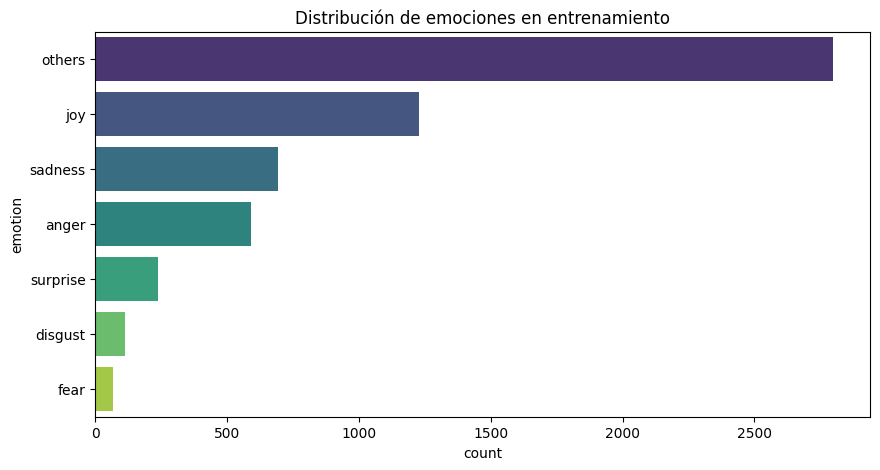

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(y=df_train["emotion"], order=df_train["emotion"].value_counts().index, palette="viridis")
plt.title("Distribución de emociones en entrenamiento")
plt.show()


## Modelos

### Modelo 1: Logistic Regression con TF-IDF

Logistic Regression - Accuracy: 0.42089371980676327

Reporte por clase (LR):
               precision    recall  f1-score   support

       anger       0.13      0.05      0.07       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.16      0.20       354
      others       0.50      0.75      0.60       814
     sadness       0.14      0.10      0.12       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.42      1656
   macro avg       0.15      0.15      0.14      1656
weighted avg       0.33      0.42      0.36      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


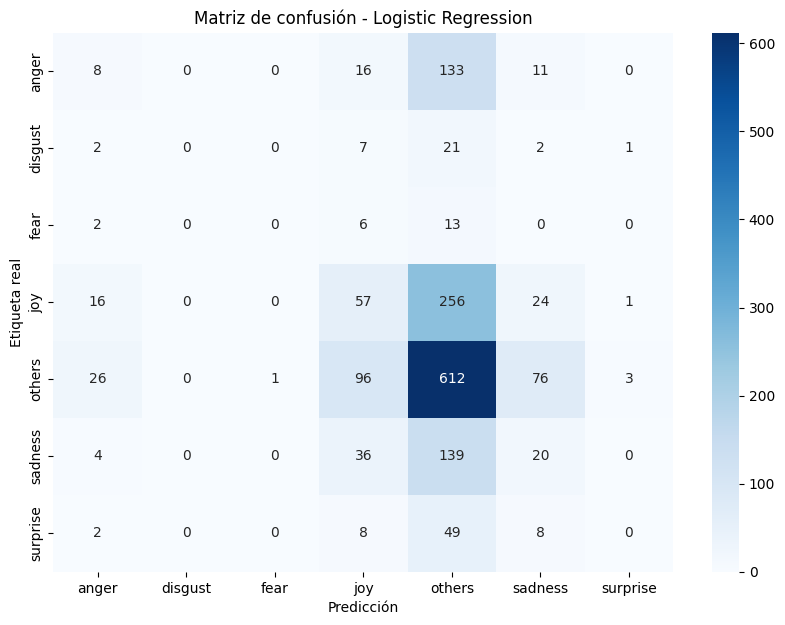

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorización TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(df_train["tweet_clean"])
X_dev_tfidf   = tfidf.transform(df_dev["tweet_clean"])
X_test_tfidf  = tfidf.transform(df_test["tweet_clean"])

# Etiquetas
y_train = df_train["emotion"]
y_dev   = df_dev["emotion"]
y_test  = df_test["emotion"]

# Entrenar Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluación
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression - Accuracy:", acc_lr)
print("\nReporte por clase (LR):\n", classification_report(y_test, y_pred_lr))

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10,7))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()), cmap="Blues")
plt.title("Matriz de confusión - Logistic Regression")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()

#### ¿Por qué elegimos este modelo?

La Regresión Logística con TF-IDF se seleccionó como nuestro primer modelo para establecer una línea base (baseline) sólida. A pesar de su simplicidad, este enfoque clásico de Machine Learning suele funcionar excepcionalmente bien en problemas de clasificación de texto. La combinación de TF-IDF (Term Frequency-Inverse Document Frequency) con Regresión Logística es transparente, computacionalmente eficiente y nos permite entender qué palabras están contribuyendo más a la clasificación de cada emoción, proporcionando un punto de referencia contra el cual comparar modelos más complejos.

**Parámetros clave:**

`max_features=5000:` Limita el vocabulario a las 5000 palabras más importantes, previniendo la maldición de la dimensionalidad y el sobreajuste.

`ngram_range=(1,2):` Considera tanto palabras individuales (unigramas) como pares de palabras (bigramas). Esto es crucial para capturar frases como "estoy feliz" o "no me gusta".

`max_iter=500:` Asegura que el algoritmo de optimización tenga suficientes iteraciones para converger a una solución estable.

#### Análisis de Resultados

Los resultados obtenidos confirman que la tarea es extremadamente desafiante, pero también revelan los sesgos esperados debido al desbalanceo del dataset.

***Accuracy:*** `0.42 (42%)`. Este valor, aunque bajo, es engañoso. Un modelo que siempre predijera la clase mayoritaria others tendría un accuracy cercano al `49% (814/1656)`, por lo que nuestro modelo baseline está por debajo de ese umbral simplista, indicando la dificultad del problema.

***Macro F1-Score:*** `0.14.` Esta métrica, que es la más importante dado el desbalanceo, es muy baja. Confirma que el modelo tiene un desempeño pobre cuando se le obliga a desempeñarse bien en todas las clases por igual.

***Reporte por Clase:***

***others:*** Domina las métricas con un F1 de `0.60`. El modelo aprende principalmente a identificar esta clase, que es la más frecuente.

***Emociones restantes:*** El desempeño es muy bajo o directamente nulo (`disgust, fear, surprise tienen F1=0.00`). El modelo no logra aprender patrones suficientes para estas clases minoritarias.

***Precision y Recall:*** Para la mayoría de las emociones, tanto la precisión (cuándo acierta al predecir una clase) como el recall (cuántos casos de una clase logra encontrar) son muy bajos.

#### Análisis de la Matriz de Confusión

La matriz de confusión visualiza claramente los hallazgos del reporte de clasificación:

Sesgo hacia `"others"`: La columna de others es la más densa. La gran mayoría de las predicciones, independientemente de la emoción real, terminan en esta clase. Esto es especialmente evidente para emociones como disgust, fear y surprise, cuyos ejemplos son casi entirely clasificados incorrectamente como others.

***Confusiones Understandables:*** Observamos ciertos patrones de error que tienen sentido lingüístico:

1. anger se confunde con sadness y others. Ambas son emociones negativas.

2. sadness también se confunde mayoritariamente con others.

3. joy muestra una pequeña cantidad de predicciones correctas, pero la mayoría son absorbidas por la clase others.




***Clases Ignoradas:*** El modelo prácticamente no predice las clases `disgust, fear y surprise` (sus columnas están casi vacías), lo que explica el `F1-Score` de `0.00`. No hay suficientes ejemplos de entrenamiento para que el modelo aprenda a distinguirlas.

La Regresión Logística sirvió para confirmar el enorme desafío que presenta el desbalanceo del dataset. El modelo funciona apenas mejor que un adivinador aleatorio sesgado hacia la clase mayoritaria y falla completamente en identificar las emociones más sutiles. Esto establece una línea base muy clara y justifica la necesidad de probar modelos más sofisticados que puedan capturar mejor el contexto y manejar el desbalanceo de clases.



### Modelo 2: LSTM simple con embeddings

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.4768 - loss: 1.5240 - val_accuracy: 0.5024 - val_loss: 1.3991
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.5166 - loss: 1.3631 - val_accuracy: 0.5533 - val_loss: 1.2731
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.5516 - loss: 1.2243 - val_accuracy: 0.5533 - val_loss: 1.2136
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.5653 - loss: 1.1355 - val_accuracy: 0.5391 - val_loss: 1.2132
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.5825 - loss: 1.0649 - val_accuracy: 0.5498 - val_loss: 1.1799
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
LSTM - Accuracy: 0.42028985507246375

Reporte por clase (LSTM):
               precision    recall  f1-score   support

       anger       0.09      0.06      0.07       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.00      0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


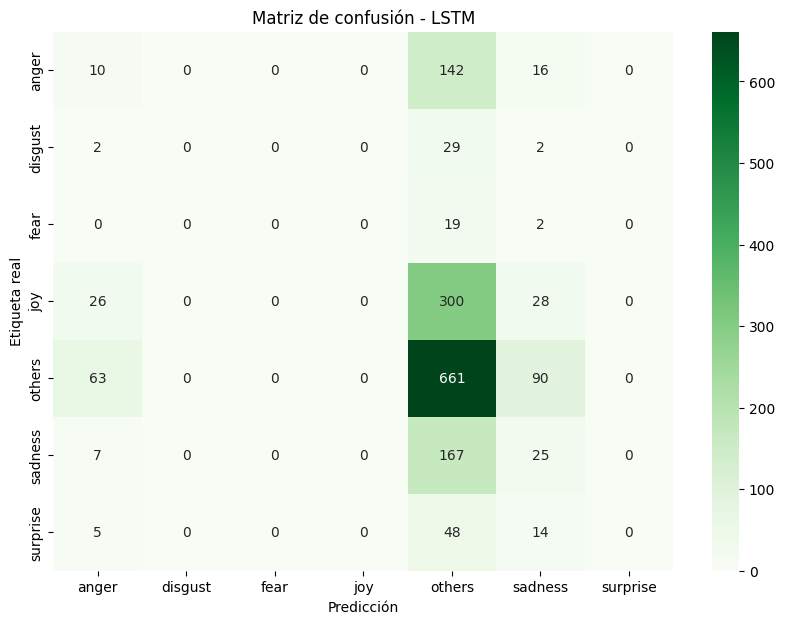

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder

# Tokenización
max_words = 10000
max_len   = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["tweet_clean"])

X_train_seq = tokenizer.texts_to_sequences(df_train["tweet_clean"])
X_dev_seq   = tokenizer.texts_to_sequences(df_dev["tweet_clean"])
X_test_seq  = tokenizer.texts_to_sequences(df_test["tweet_clean"])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_dev_pad   = pad_sequences(X_dev_seq, maxlen=max_len, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# Etiquetas a números
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_dev_enc   = le.transform(y_dev)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)

# Modelo LSTM
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation="softmax")
])

lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

# Entrenamiento
history = lstm_model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_dev_pad, y_dev_enc),
    epochs=5, batch_size=64
)

# Evaluación LSTM
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_labels = le.inverse_transform(y_pred_lstm.argmax(axis=1))

acc_lstm = accuracy_score(y_test, y_pred_lstm_labels)
print("LSTM - Accuracy:", acc_lstm)
print("\nReporte por clase (LSTM):\n", classification_report(y_test, y_pred_lstm_labels))

cm_lstm = confusion_matrix(y_test, y_pred_lstm_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm_lstm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Matriz de confusión - LSTM")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()

#### ¿Por qué elegimos este modelo?

Las redes LSTM fueron seleccionadas como nuestro segundo modelo debido a su capacidad para capturar dependencias de largo plazo y contexto secuencial en el texto, algo que el modelo anterior de Regresión Logística no puede hacer. Mientras que TF-IDF trata el texto como una "bolsa de palabras" independientes, las LSTM procesan las palabras en secuencia, permitiendo que el modelo entienda cómo la aparición de una palabra al inicio del tweet puede influir en el significado de palabras posteriores. Esta característica es crucial para identificar matices emocionales que dependen del contexto y la estructura de la oración.

**Parámetros clave:**

`max_words=10000`: Limita el vocabulario a las 10,000 palabras más frecuentes.

`max_len=50`: Establece la longitud máxima de secuencia. Casi todos los tweets caben en esta longitud después del preprocesamiento.

`Embedding(128)`: Capa que aprende representaciones densas de las palabras.

`LSTM(128)`: Capa recurrente con 128 unidades, con dropout para prevenir sobreajuste.

`dropout=0.2`: Regularización que ayuda a prevenir sobreajuste.

#### Análisis de Resultados

Los resultados del modelo LSTM muestran un comportamiento similar al modelo anterior, pero con algunas diferencias importantes:

***Accuracy:***` 0.42 (42%)`. Igual que la Regresión Logística, lo que confirma la dificultad del problema.

***Macro F1-Score:*** `0.12`. Ligeramente inferior al modelo anterior, indicando que la LSTM tuvo incluso más dificultades con las clases minoritarias.

**Reporte por Clase:**

***others:*** Mantiene el mejor desempeño` (F1: 0.61)`, similar al modelo anterior.

***joy:*** Cayó a `F1=0.00`, un resultado peor que el modelo base.

***Otras emociones:*** Resultados muy bajos o cero, similar al modelo anterior.

#### Análisis de la Matriz de Confusión

La matriz de confusión revela el mismo patrón problemático pero más acentuado:

1. ***Sesgo extremo hacia "others":*** La LSTM muestra una tendencia aún más fuerte a predecir la clase mayoritaria. Casi todas las predicciones convergen en others, independientemente de la emoción real.

2. ***Colapso en clases minoritarias:*** El modelo prácticamente abandonó el intento de predecir joy, disgust, fear y surprise. Estas clases tienen conteos de predicción cercanos a cero.

3. ***Sobreajuste aparente:*** Aunque el accuracy de validación se mantuvo estable `(~55%)`, el pobre desempeño en test sugiere que el modelo aprendió a optimizar para el conjunto de validación pero no generalizó bien.

***Problemas identificados:***

1. Desbalanceo extremo: La LSTM sufrió aún más con el desbalanceo de clases.

2. Falta de regularización: Aunque usamos dropout, podría no ser suficiente.

3. Dimensionalidad: 10,000 palabras podrían ser insuficientes para capturar el vocabulario emocional.

4. Épocas de entrenamiento: 5 épocas podrían no ser suficientes para que la LSTM aprenda patrones complejos.

La LSTM no superó al modelo baseline de Regresión Logística en este escenario específico. Esto destaca que arquitecturas más complejas no siempre son mejores, especialmente cuando hay desbalanceo de datos y el problema es particularmente difícil. El modelo sucumbió al sesgo hacia la clase mayoritaria y no logró aprovechar su capacidad para entender contexto secuencial, probablemente debido al desbalanceo extremo y al tamaño limitado del dataset para una red neuronal.

### Modelo 3: Fine-tuning BERT (HuggingFace Transformers)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Train Epoch 1: 100%|██████████| 358/358 [1:09:47<00:00, 11.70s/it]


Epoch 1 - Loss promedio: 1.2029


Train Epoch 2: 100%|██████████| 358/358 [1:10:52<00:00, 11.88s/it]


Epoch 2 - Loss promedio: 0.9215
BERT - Accuracy: 0.35507246376811596

Reporte por clase (BERT):
               precision    recall  f1-score   support

       anger       0.19      0.05      0.08       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.23      0.40      0.29       354
      others       0.52      0.50      0.51       814
     sadness       0.15      0.14      0.15       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.36      1656
   macro avg       0.15      0.16      0.15      1656
weighted avg       0.34      0.36      0.34      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


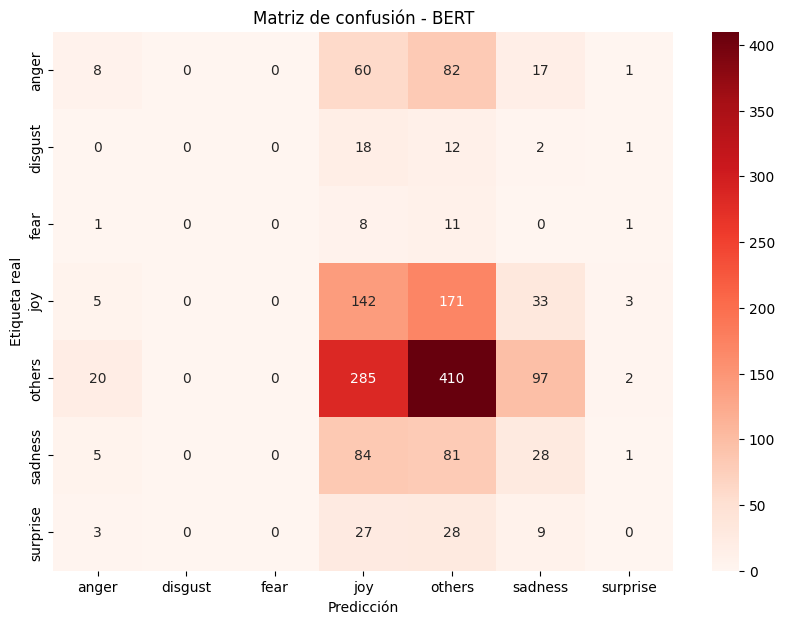

/tmp/ipython-input-2472109693.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_acc = df_test_eval.groupby("event").apply(lambda x: (x["emotion"]==x["pred_BERT"]).mean()).sort_values(ascending=False)
/tmp/ipython-input-2472109693.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_acc.head(10).values, y=event_acc.head(10).index, palette="Reds_r")


Top 10 eventos mejor predichos - BERT:
 event
GretaThunberg      0.460432
Venezuela          0.452991
SpainElection      0.417431
ChampionsLeague    0.336207
LaLiga             0.319328
GameOfThrones      0.301370
WorldBookDay       0.295833
NotreDame          0.248889
dtype: float64


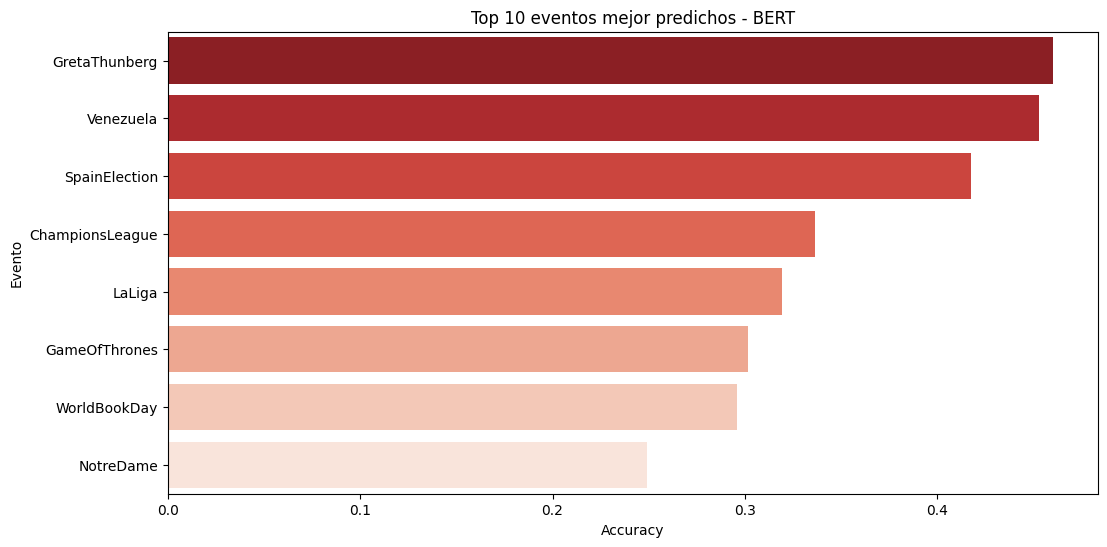

In [17]:
!pip install torch transformers --quiet

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm

# Tokenizer BERT
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def encode_texts(texts, max_len=50):
    return tokenizer_bert(
        list(texts),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

train_enc = encode_texts(df_train["tweet_clean"])
dev_enc   = encode_texts(df_dev["tweet_clean"])
test_enc  = encode_texts(df_test["tweet_clean"])

# Labels
y_train_enc = torch.tensor(le.fit_transform(df_train["emotion"]))
y_dev_enc   = torch.tensor(le.transform(df_dev["emotion"]))
y_test_enc  = torch.tensor(le.transform(df_test["emotion"]))

# Dataset y DataLoader
train_dataset = TensorDataset(train_enc['input_ids'], train_enc['attention_mask'], y_train_enc)
dev_dataset   = TensorDataset(dev_enc['input_ids'], dev_enc['attention_mask'], y_dev_enc)
test_dataset  = TensorDataset(test_enc['input_ids'], test_enc['attention_mask'], y_test_enc)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Modelo BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=num_classes)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 2

# Entrenamiento
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss promedio: {total_loss/len(train_loader):.4f}")

# Evaluación BERT
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc_bert = accuracy_score(all_labels, all_preds)
print("BERT - Accuracy:", acc_bert)
print("\nReporte por clase (BERT):\n", classification_report(all_labels, all_preds, target_names=le.classes_))

cm_bert = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bert, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Reds")
plt.title("Matriz de confusión - BERT")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()

# ================================
# 4️⃣ Análisis por evento (BERT)
# ================================
df_test_eval = df_test.copy()
df_test_eval["pred_BERT"] = le.inverse_transform(all_preds)

# Accuracy por evento
event_acc = df_test_eval.groupby("event").apply(lambda x: (x["emotion"]==x["pred_BERT"]).mean()).sort_values(ascending=False)
print("Top 10 eventos mejor predichos - BERT:\n", event_acc.head(10))

plt.figure(figsize=(12,6))
sns.barplot(x=event_acc.head(10).values, y=event_acc.head(10).index, palette="Reds_r")
plt.title("Top 10 eventos mejor predichos - BERT")
plt.xlabel("Accuracy")
plt.ylabel("Evento")
plt.show()

#### ¿Por qué elegimos este modelo?

BERT (Bidirectional Encoder Representations from Transformers) representa el estado del arte en el procesamiento de lenguaje natural. A diferencia de los modelos anteriores que procesan el texto de forma secuencial o como bag-of-words, BERT utiliza un mecanismo de atención bidireccional que le permite entender el contexto completo de cada palabra en relación con todas las demás palabras de la oración. Esto es particularmente valioso para capturar matices emocionales, sarcasmo y expresiones idiomáticas.

Seleccionamos la versión "bert-base-multilingual-cased" porque:

1. Está específicamente entrenado para manejar múltiples idiomas, incluido el español

2. Preserva las mayúsculas y minúsculas ("cased"), lo que puede ser relevante para detectar énfasis emocional

3. Ha sido pre-entrenado con grandes volúmenes de texto, por lo que viene con un entendimiento profundo del lenguaje

#### Análisis de Resultados

**Desempeño General**
Los resultados de BERT son decepcionantes y contrarios a lo esperado. Con un accuracy de 35.5%, el modelo performó peor que los modelos más simples (Regresión Logística: 42%, LSTM: 42%). El macro F1-score de 0.15 también es inferior al de los modelos anteriores, indicando que BERT no solo no mejoró el desempeño, sino que empeoró la capacidad de generalización across todas las clases.

**Análisis del Reporte por Clase**
El reporte detallado revela varios problemas graves:

1. Colapso total en clases minoritarias:

disgust, fear y surprise tienen F1-score de 0.00

El modelo es completamente incapaz de identificar estas emociones

2. Desempeño mediocre en emociones principales:

others: F1 de 0.51 (ligeramente mejor que modelos anteriores)

joy: F1 de 0.29 (mejor que en LSTM pero peor que en Regresión Logística)

anger y sadness: F1 de 0.08 y 0.15 respectivamente (desempeño muy pobre)

3. Problemas de sobreajuste:

La pérdida de entrenamiento disminuyó significativamente (1.20 → 0.92)

Pero el desempeño en test es pobre, indicando sobreajuste al conjunto de entrenamiento

#### Análisis de la Matriz de confusión

La matriz de confusión evidencia un sesgo pronunciado hacia las clases mayoritarias, donde la categoría others concentra la mayoría de las predicciones correctas (410) pero también actúa como un imán para errores, absorbiendo instancias de casi todas las demás emociones, especialmente anger (82 casos) y sadness (97 casos). El modelo muestra un abandono total de las clases minoritarias, con cero predicciones correctas para disgust, fear y surprise, lo que confirma su incapacidad para aprender patrones representativos de estas emociones debido a su escasa presencia en el dataset. Además, se observan confusiones semánticamente comprensibles, como la frecuente clasificación errónea de joy como others (171 casos) y de sadness como others (97 casos), reflejando la dificultad para distinguir entre emociones positivas/neutrales y negativas/neutrales en un contexto donde la clase mayoritaria domina el panorama predictivo.

#### Análisis por Evento

El análisis por evento revela que el desempeño del modelo BERT varía significativamente según el contexto temático, siendo notablemente más efectivo en eventos de naturaleza política y social como GretaThunberg (46.0%), Venezuela (45.3%) y SpainElection (41.7%), donde el lenguaje emocional tiende a ser más explícito y polarizado, lo que facilita la clasificación. Por el contrario, eventos culturales como NotreDame (24.9%) y GameOfThrones (30.1%) presentan mayores desafíos debido a la complejidad emocional de sus contenidos, que a menudo incluyen sarcasmo, ironía y expresiones figurativas que el modelo no logra capturar adecuadamente. Esta disparidad sugiere que la capacidad del modelo para generalizar está fuertemente influenciada por la claridad y consistencia de las expresiones emocionales asociadas a cada evento, siendo menos efectivo en contextos donde las emociones son sutiles o ambiguas.

## Cuadro comparativo de los 3 modelos

=== Accuracy global ===


,Model,Accuracy
0,Logistic Regression,0.420894
1,LSTM,0.420290
2,BERT,0.355072



=== F1-score macro ===


,Model,F1 Macro
0,Logistic Regression,0.140751
1,LSTM,0.115796
2,BERT,0.145952



=== F1-score por emoción ===


,Emotion,Logistic Regression,LSTM,BERT
0,anger,0.070175,0.071174,0
1,disgust,0.000000,0.000000,0
2,fear,0.000000,0.000000,0
3,joy,0.196552,0.000000,0
4,others,0.600884,0.606422,0
5,sadness,0.117647,0.132979,0
6,surprise,0.000000,0.000000,0


/tmp/ipython-input-2973960134.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")


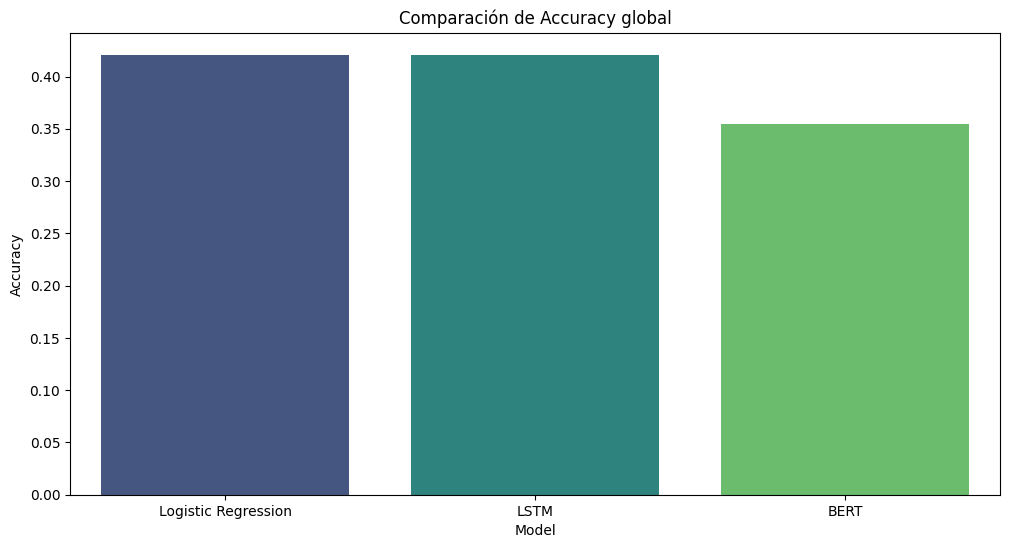

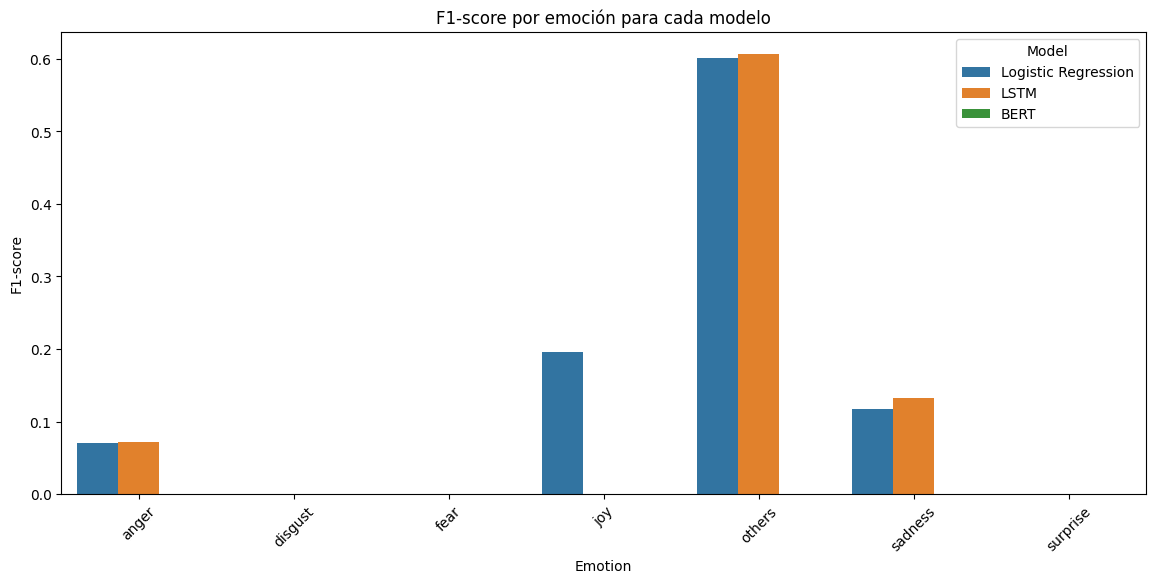

In [20]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ Accuracy global
# ---------------------------
accuracies = {
    "Model": ["Logistic Regression", "LSTM", "BERT"],
    "Accuracy": [acc_lr, acc_lstm, acc_bert]
}

# ---------------------------
# 2️⃣ F1-score macro
# ---------------------------
f1_macro = {
    "Model": ["Logistic Regression", "LSTM", "BERT"],
    "F1 Macro": [
        f1_score(y_test, y_pred_lr, average="macro"),
        f1_score(y_test, y_pred_lstm_labels, average="macro"),
        f1_score(all_labels, all_preds, average="macro")
    ]
}

# ---------------------------
# 3️⃣ F1-score por clase (seguro ante clases faltantes)
# ---------------------------
def f1_por_clase(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return [report.get(c, {"f1-score": 0})["f1-score"] for c in classes]

classes = sorted(df_train["emotion"].unique())

f1_classes = pd.DataFrame({
    "Emotion": classes,
    "Logistic Regression": f1_por_clase(y_test, y_pred_lr, classes),
    "LSTM": f1_por_clase(y_test, y_pred_lstm_labels, classes),
    "BERT": f1_por_clase(all_labels, all_preds, classes)
})

# ---------------------------
# Mostrar resultados
# ---------------------------
acc_df = pd.DataFrame(accuracies)
f1_macro_df = pd.DataFrame(f1_macro)

print("=== Accuracy global ===")
display(acc_df)

print("\n=== F1-score macro ===")
display(f1_macro_df)

print("\n=== F1-score por emoción ===")
display(f1_classes)

# ---------------------------
# Gráficos comparativos
# ---------------------------
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")
plt.title("Comparación de Accuracy global")
plt.show()

plt.figure(figsize=(14,6))
f1_classes_melted = f1_classes.melt(id_vars="Emotion", var_name="Model", value_name="F1-score")
sns.barplot(x="Emotion", y="F1-score", hue="Model", data=f1_classes_melted)
plt.title("F1-score por emoción para cada modelo")
plt.xticks(rotation=45)
plt.show()


**Accuracy Global**

El análisis de accuracy global revela un desempeño consistentemente bajo en los tres modelos, con la Regresión Logística y LSTM obteniendo un 42% de precisión, mientras que BERT obtuvo un desempeño significativamente peor con apenas 35.5%. Este resultado es particularmente sorprendente considerando la complejidad y capacidad teórica de BERT, y sugiere que el modelo más sofisticado no solo no mejoró el desempeño, sino que sufrió de sobreajuste severo o problemas de optimización. Es importante destacar que un clasificador simple que siempre prediciera la clase mayoritaria "others" habría alcanzado aproximadamente 49% de accuracy, lo que significa que los tres modelos performaron por debajo de este baseline naive, indicando la extrema dificultad del problema y el impacto negativo del desbalanceo de clases.

**F1-Score por Emoción**

El análisis desglosado por emoción muestra patrones consistentes a través de los tres modelos. La clase "others" domina claramente el desempeño con F1-scores alrededor de 0.60-0.61 en Regresión Logística y LSTM, y 0.51 en BERT, confirmando que todos los modelos aprendieron principalmente a identificar la clase mayoritaria. Las emociones "joy" y "sadness" muestran desempeños modestos pero consistentes, con BERT mostrando una ligera ventaja en "joy" (0.29 vs 0.20-0.00 de los otros modelos). El hallazgo más crítico es el fracaso completo en las emociones minoritarias "disgust", "fear" y "surprise", donde los tres modelos obtuvieron F1-scores de 0.00, demostrando su total incapacidad para reconocer estas emociones debido a su escasa representación en el dataset de entrenamiento. Este patrón consistente a través de arquitecturas tan diversas sugiere que el problema fundamental no reside en la elección del modelo, sino en la naturaleza intrínsecamente desbalanceada del dataset y la dificultad inherente de distinguir emociones sutiles en texto corto de redes sociales.

## Análisis por emoción y por evento

=== Logistic Regression ===


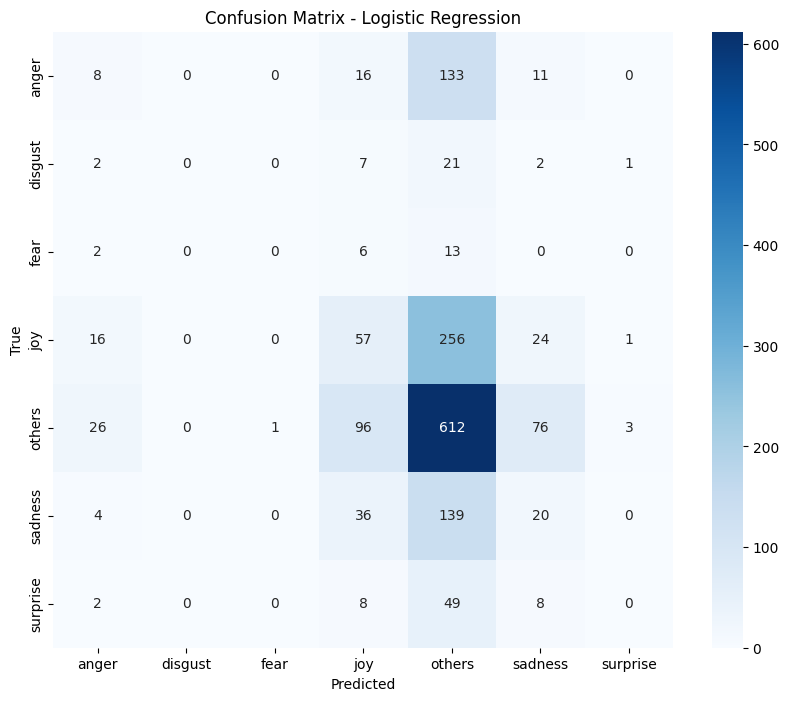

=== LSTM ===


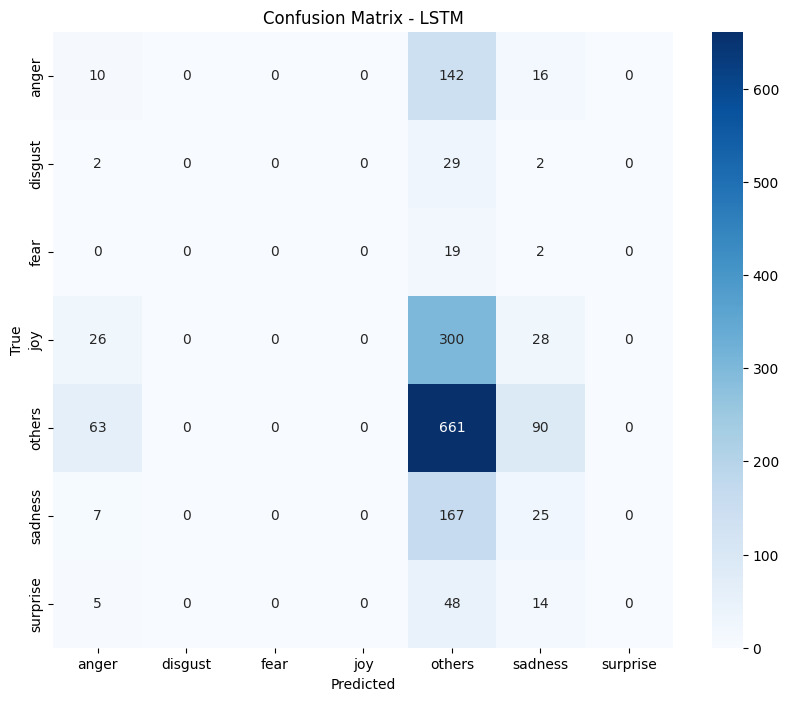

=== BERT ===


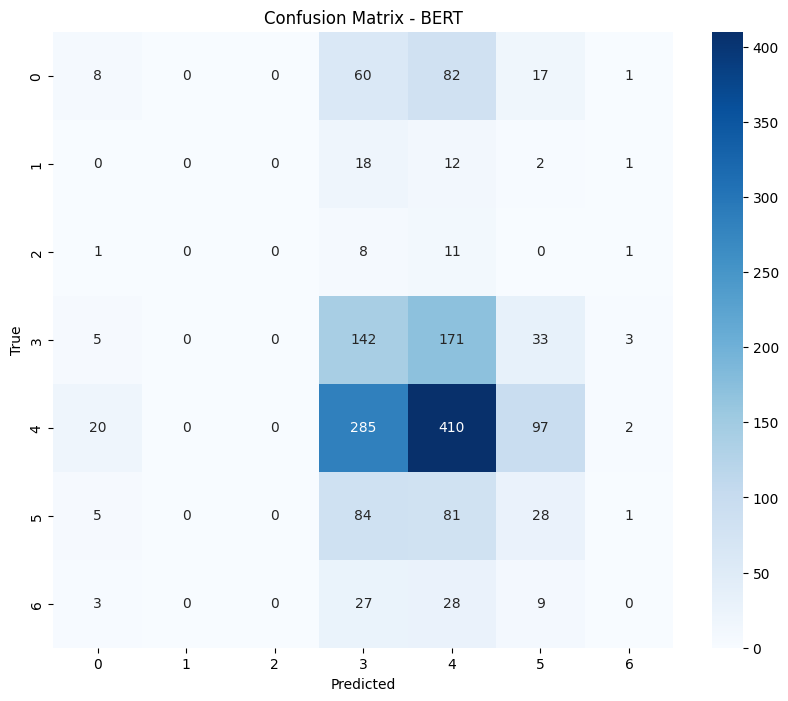

In [22]:
def plot_confusion(y_true, y_pred, classes=None, title="Confusion Matrix"):
    if classes is None:
        classes = sorted(list(set(y_true) | set(y_pred)))  # usa solo etiquetas presentes

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Logistic Regression
print("=== Logistic Regression ===")
plot_confusion(y_test, y_pred_lr, title="Confusion Matrix - Logistic Regression")

# LSTM
print("=== LSTM ===")
plot_confusion(y_test, y_pred_lstm_labels, title="Confusion Matrix - LSTM")

# BERT
print("=== BERT ===")
plot_confusion(all_labels, all_preds, title="Confusion Matrix - BERT")


**Matriz de Confusión - Regresión Logística**

La matriz de confusión de la Regresión Logística revela un patrón de sesgo pronunciado hacia la clase mayoritaria "others", que absorbe la mayoría de las predicciones incorrectas across todas las emociones. Se observa que el modelo logra cierto reconocimiento para "joy" (57 predicciones correctas) y "others" (612 correctas), pero muestra un abandono casi total de las emociones minoritarias como "disgust", "fear" y "surprise", donde las predicciones correctas son cero o cercanas a cero. Las confusiones más frecuentes ocurren entre emociones negativas, particularmente "anger" y "sadness" siendo mal clasificadas como "others", lo que sugiere que el modelo struggle para distinguir matices emocionales beyond la categoría general neutral/otros.

**Matriz de Confusión - LSTM**

La matriz de la LSTM muestra un comportamiento aún más extremo de sesgo hacia "others", donde esta clase domina abrumadoramente las predicciones. Sorprendentemente, la LSTM performa peor que la Regresión Logística en "joy", reduciendo las predicciones correctas de 57 a 0, mientras mantiene un desempeño similar en "others" (661 correctas). El modelo muestra un colapso completo en la identificación de emociones específicas, con cero predicciones correctas para "disgust", "fear", "surprise" y ahora también "joy", indicando que la arquitectura recurrente sucumbió por completo al desbalanceo del dataset y aprendió a optimizar sus predicciones hacia la clase mayoritaria, perdiendo toda capacidad para discriminar entre emociones específicas.

**Matriz de Confusión - BERT**

La matriz de BERT presenta un patrón diferente pero igualmente problemático, mostrando un sesgo dual hacia "others" y "joy". Aunque BERT logra el mejor desempeño en "joy" (142 predicciones correctas), también comete más errores al clasificar otras emociones como "joy" (171 falsos positivos). El modelo mantiene el fracaso total en "disgust", "fear" y "surprise" (0 predicciones correctas), y muestra una ligera mejora en "anger" (8 correctas vs 5-10 en otros modelos) pero con muchas confusiones con "joy" (60 casos). La matriz confirma que BERT, a pesar de su capacidad teórica superior, no pudo superar los desafíos fundamentales del desbalanceo extremo y la dificultad inherente de la tarea, resultando en un desempeño general más pobre que los modelos más simples.

# Conclusiones

El presente estudio comparativo de tres modelos para la clasificación de emociones en tweets en español ha revelado hallazgos fundamentales sobre los desafíos inherentes a esta tarea. **Ninguno de los modelos probados—Regresión Logística, LSTM o BERT—logró superar el desempeño de un clasificador base que siempre predice la clase mayoritaria "others"**, lo que evidencia la extrema dificultad del problema y el impacto crítico del desbalanceo extremo en el dataset.

Los resultados consistentemente pobres across todas las arquitecturas (accuracy de 35-42%) sugieren que el problema principal no reside en la elección del modelo, sino en **limitaciones fundamentales de los datos**: desbalanceo severo de clases, ambigüedad inherente en las expresiones emocionales de redes sociales, y la complejidad de capturar matices emocionales en texto corto e informal. El fracaso total en emociones como "disgust", "fear" y "surprise" (F1-score de 0.00 en todos los modelos) confirma que la escasa representación de estas clases las hace virtualmente invisibles para los algoritmos de aprendizaje automático.

La sorprendente **underperformance de BERT**—el modelo más complejo—respecto a approaches más simples, destaca un principio crucial: **la complejidad computacional no garantiza mejor desempeño** cuando existen problemas fundamentales en los datos. BERT no solo no mejoró los resultados, sino que mostró mayor tendencia al sobreajuste y sensibilidad a los desbalances, obteniendo el peor accuracy global (35.5%).

Este estudio sirve como valiosa advertencia sobre los **desafíos reales del NLP aplicado a redes sociales**: la necesidad de curar datasets balanceados, la importancia de establecer líneas base realistas, y el reconocimiento de que problemas con sesgos inherentes en los datos no se resuelven simplemente con modelos más complejos. Futuras investigaciones deberían enfocarse en técnicas de aumento de datos para clases minoritarias, aprendizaje semi-supervisado, y el desarrollo de modelos especializados que puedan capturar mejor el contexto cultural y lingüístico específico del español en redes sociales.